# XGBoost的参数空间与超参数优化

## 1 确定XGBoost优化的参数空间

丰富的超参数为集成算法提供了无限的可能，以降低偏差为目的的Boosting算法们在调参之后的表现更是所向披靡，因此XGB00st的超参数自动优化也是一个重要的课题。在过去的课程当中我们已经讲解过大量关于树模型参数影响力的内容，因此在阅读本章之前，强烈建议学习GBDT课程当中超参数空间相关的内容。属于GBDT的参数空间会极大程度地帮助你理解XGBoost的参数空间。

对任意集成算法进行超参数优化之前，我们需要明确两个基本事实：

1、不同参数对算法结果的影响力大小

2、确定用于搜索的参数空间

对XGBoost来说，我们可以大致如下排列各个参数对算法的影响：

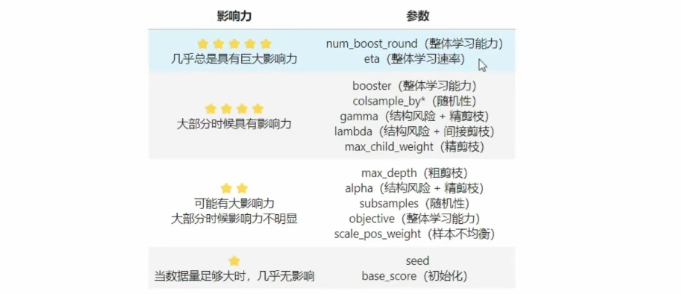

比起其他树的集成算法，XGBoost有大量通过影响建树过程而影响整体模型的参数（比如gamma,lambda等），这些参数以较为复杂的方式共同作用、影响模型的最终结果，因此他们的影响力不是线性的，也不总是能在调参过程中明显地展露出来，但调节这些参数大多数时候都能对模型有影响，因此大部分与结构风险相关的参数都被评为4星参数了，相对的，对XGB00st来说总是具有巨大影响力的参数就只有迭代次数与学习率了

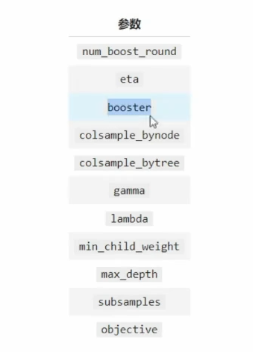

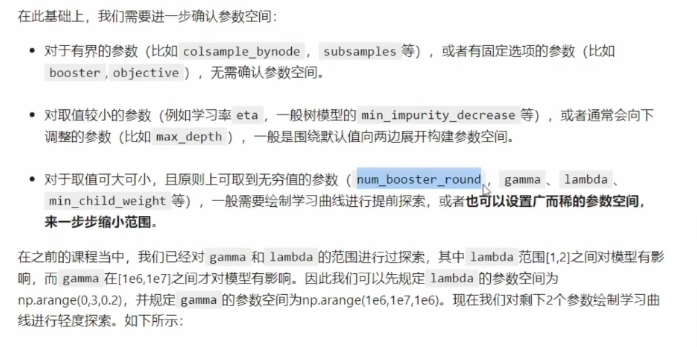

In [ ]:
import xgboost as xgb
data_xgb = xgb.DMatrix('agaricus.txt.train')

# 定义一个函数，用来检测模型迭代完毕后的过拟合情况
def overfitcheck(result):
    return (result.iloc[-1, 2] - result.iloc[-1, 0]).min()

* num boost round
  
一般迭代次数默认为100次，因此我们通常会主动在300或者500以内进行尝试：

In [ ]:
import numpy as np
train = []
test = []
option = np.arange(10, 300, 10)
overfit = []
for i in option:
    params = {"max_depth":5,
              "seed":1412,
              "eta": 0.1,
              "nthred":16}
    result = xgb.cv(params, data_xgb, num_boost_round=i, nfold=5, seed=1412)
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1, 0])
    test.append(result.iloc[-1, 2])
import matplotlib.pyplot as plt
plt.plot(option, train, label='train')
plt.plot(option, test, label='test')

* min_child_weight

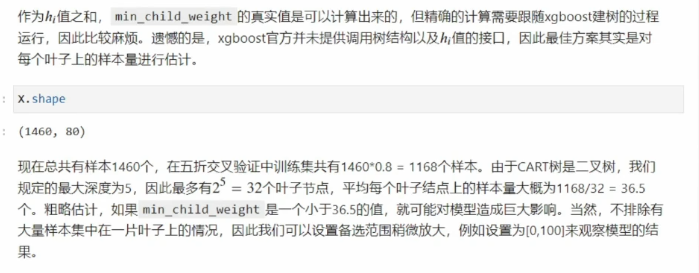

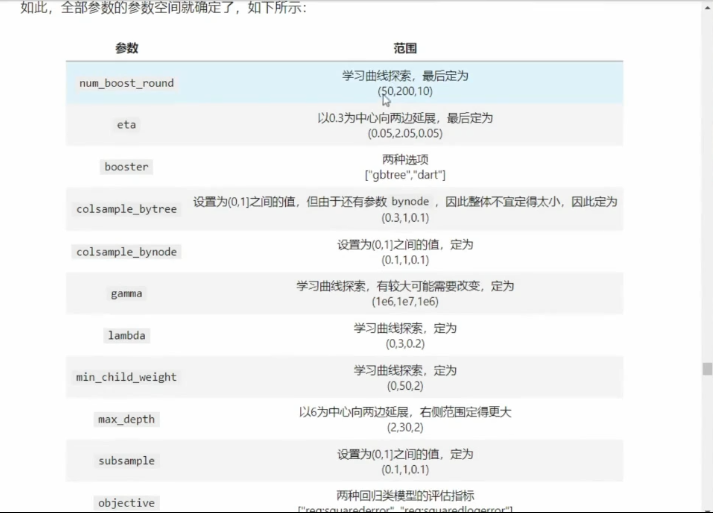

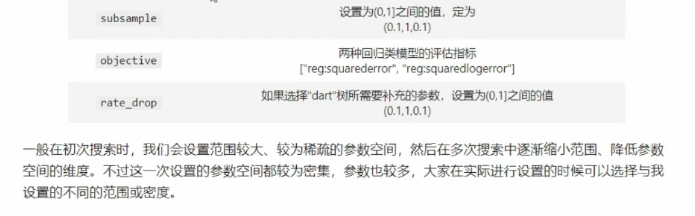

## 基于TEP对XGBoost进行优化

In [3]:
# 日常使用库与算法
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import time
import xgboost as xgb

# 导入优化算法
import hyperopt
from hyperopt import fmin, tpe, hp, partial, Trials, space_eval,tpe
from hyperopt.early_stop import no_progress_loss

In [ ]:
data = pd.read_csv('data.csv')

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

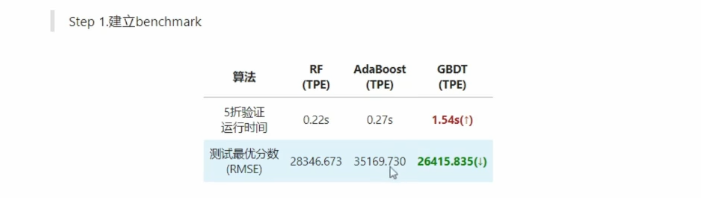

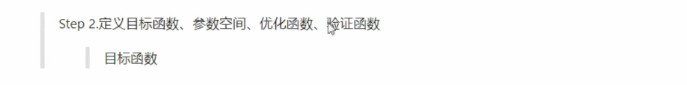

In [ ]:
def hyperopt_objective(params):
    paramsforxgb = {
        "eta":params["eta"],
        "booster":params["booster"],
        "colsample_bytree":params["colsample_bytree"],
        "colsample_bynode":params["colsample_bynode"],
        "gamma":params["gamma"],
        "lambda":params["lambda"],
        "min_child_weight":params["min_child_weight"],
        "max_depth":params["max_depth"],
        "subsample":params["subsample"],
        "objective":params["objective"],
        "rate_drop":params["rate_drop"],
        "nthred": 14,
        "verbosity": 0,
        "seed": 1412
    }
    result = xgb.cv(paramsforxgb, data_xgb, num_boost_round=int(params['num_boost_round']), nfold=5, seed=1412)
    return result.iloc[-1, 2]

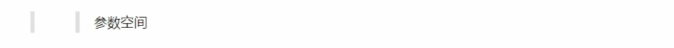

In [ ]:
param_grid_simple = {
    "num_boost_round":hp.quniform("num_boost_round", 50, 200, 10),
    "eta":hp.uniform("eta", 0.05, 2.05, 0.05),
    "booster":hp.choice("booster", ["gbtree", "dart"]),
    "colsample_bytree":hp.uniform("colsample_bytree", 0.3, 1, 0.1),
    "colsample_bynode":hp.uniform("colsample_bynode", 0.1, 1, 0.1),
    "gamma":hp.uniform("gamma", 1e6, 1e7, 1e6),
    "lambda":hp.uniform("lambda", 0.3, 0.2),
    "min_child_weight":hp.uniform("min_child_weight", 1, 50, 2),
    "max_depth":hp.quniform("max_depth", [*range(2, 30, 2)]),
    "subsample":hp.uniform("subsample", 0.1, 1, 0.1),
    "objective":hp.choice("objective", ["reg:squarederror", "reg:squaredlogerror", "reg:logistic"]),
    "rate_drop":hp.uniform("rate_drop", 0.1, 1, 0.1)
}

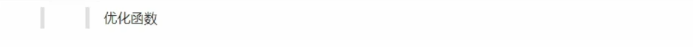

In [ ]:
def param_hyperopt(max_evals = 100):

    # 保存迭代过程
    trails = Trials()

    # 设置提前停止
    early_stop_fn = no_progress_loss(10)

    # 定义代理类型
    params_best = fmin(hyperopt_objective,
                       space=param_grid_simple,
                       algo=tpe.suggest,
                       max_evals=max_evals,
                       verbose= True,
                       trials=trails,
                       early_stop_fn=early_stop_fn)
    # 打印最优参数
    print("\n", '\n', "best params", params_best, '\n', '\n')
    return params_best, trails

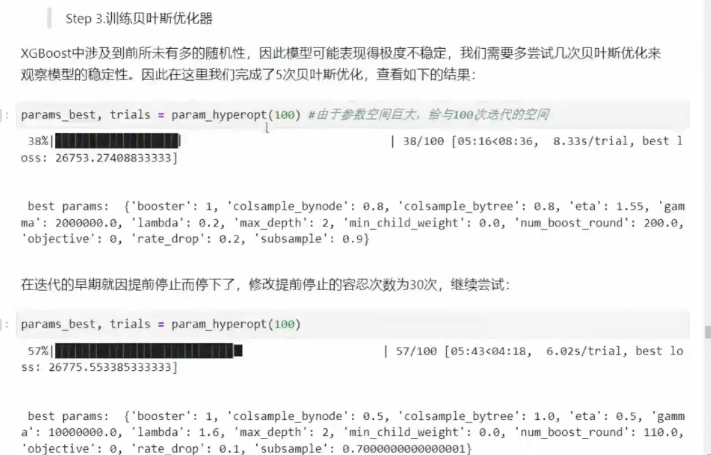

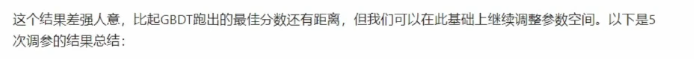

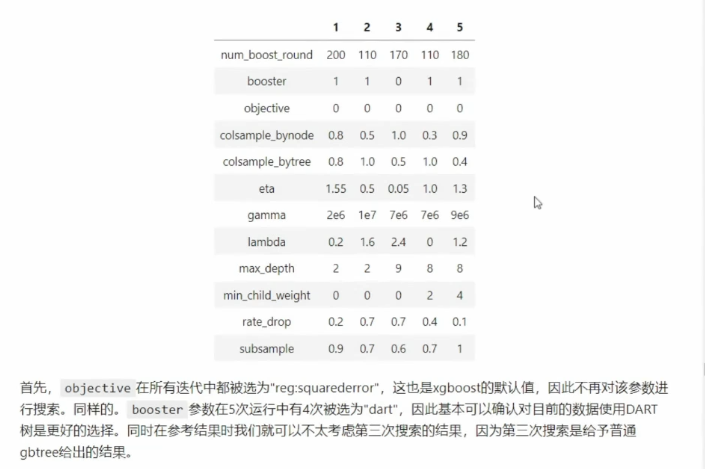

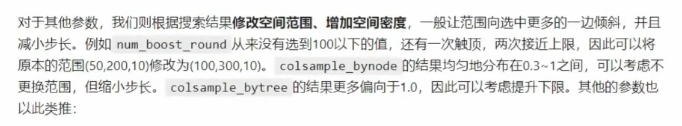

In [ ]:
param_grid_simple = {
    "num_boost_round":hp.quniform("num_boost_round", 100, 300, 10),
    "eta": hp.uniform("eta", 0.05, 2.05, 0.05),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1, 0.05),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.3, 1, 0.05),
    "gamma": hp.uniform("gamma", 5e6, 1.5e7, 5e5),
    "lambda": hp.uniform("lambda", 0, 2, 0.1),
    "min_child_weight": hp.uniform("min_child_weight", 2, 5, 1),
    "subsample": hp.uniform("subsample", 0.5, 1, 0.05),
    "rate_drop": hp.uniform("rate_drop", 0.1, 1, 0.05)
}

In [ ]:
def hyperopt_objective(params):
    paramsforxgb = {
        "eta":params["eta"],
        "colsample_bytree":params["colsample_bytree"],
        "colsample_bynode":params["colsample_bynode"],
        "gamma":params["gamma"],
        "lambda":params["lambda"],
        "min_child_weight":params["min_child_weight"],
        "max_depth":int(params["max_depth"]),
        "subsample":params["subsample"],
        "rate_drop":params["rate_drop"],
        "booster":"dart",
        "nthred": 14,
        "verbosity": 0,
        "seed": 1412
    }
    result = xgb.cv(params, 
                    data_xgb,
                    seed=1412,
                    metrics="rmse",
                    num_boost_round=int(params['num_boost_round']))
    return result.iloc[-1, 2]

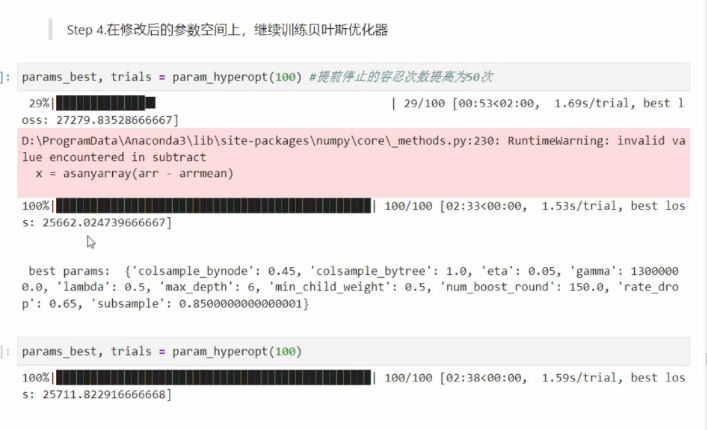

我们在经过调整后的参数空间上进行了5次搜索，其中得到的最槽糕的成绩是26307.809，但这已经是一个超越GBDT的分数。在5次搜索当中，我们得到的最佳分数是25662.024。现在我们可以尝试在验证函数上验证这一组参数：

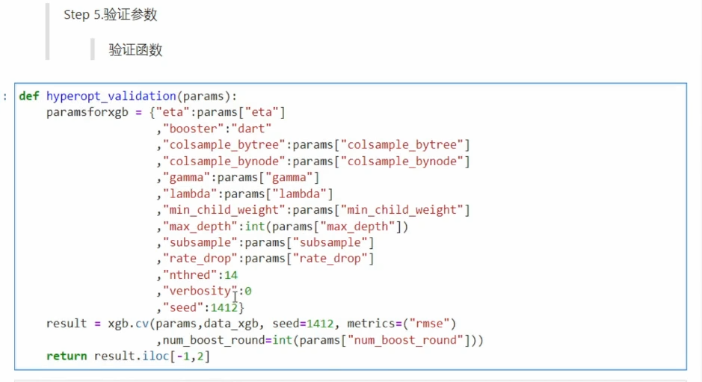

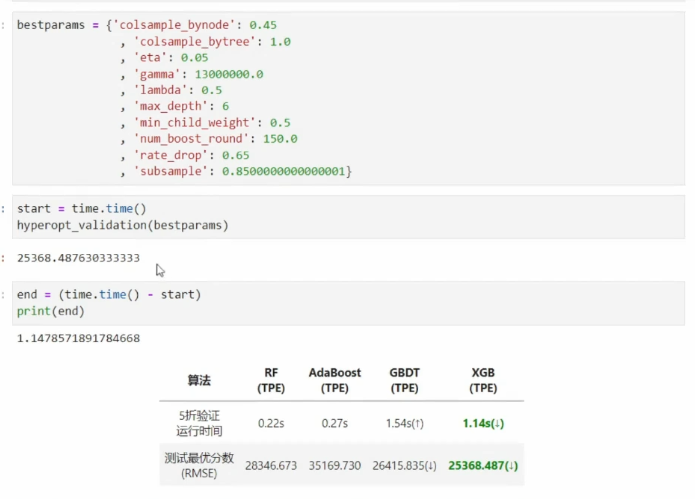

从参数的密度来看，我们还可以继续提升我们的分数，但课时有限，我们就不再继续调整了，大家可以顺着相似的思路继续往下调整，查看XGB00st是否还有更大的空间。